# Pipeline -  with best Feature Selectors
the following code splits and transforms the data. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:

df = pd.read_excel('./HYPE Dataset for Group Project.xlsx', sheet_name='HYPE-Retention')

df.drop(df[df['SUCCESS LEVEL'] == 'In Progress'].index, inplace=True)

df.info()
df[['Term1', 'Term2', 'Term3', 'Term4', 'Term6', 'Term5', 'Term7', 'Term8', 'Term9', 'Term10']] = df[
    'FUTURE TERM ENROL'].str.split('-', expand=True)
df['Term1'] = df['Term1'].astype(int)
df['Term2'] = df['Term2'].astype(int)
df['Term3'] = df['Term3'].astype(int)
df['Term4'] = df['Term4'].astype(int)
df['Term6'] = df['Term5'].astype(int)
df['Term5'] = df['Term6'].astype(int)
df['Term7'] = df['Term7'].astype(int)
df['Term8'] = df['Term8'].astype(int)
df['Term9'] = df['Term9'].astype(int)
df['Term10'] = df['Term10'].astype(int)

df['ADMIT TERM CODE'].fillna(df['ADMIT TERM CODE'].mode(), inplace=True)
df['ADMIT YEAR'] = df['ADMIT TERM CODE'].astype(str).str[:4]
df['ADMIT MONTH'] = df['ADMIT TERM CODE'].astype(str).str[4:]

df = df.groupby(["ID 2"]).apply(lambda x: x.sort_values(["ADMIT YEAR"], ascending=False)).drop_duplicates('ID 2',
                                                                                                        keep='first').reset_index(drop=True)

X = df.drop(columns=['SUCCESS LEVEL'])
y = df['SUCCESS LEVEL'] == 'Successful'
y = y.astype(int)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 642
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INTAKE TERM CODE               527 non-null    int64  
 1   ADMIT TERM CODE                526 non-null    float64
 2   ID 2                           527 non-null    int64  
 3   RECORD COUNT                   527 non-null    int64  
 4   INTAKE COLLEGE EXPERIENCE      527 non-null    object 
 5   PRIMARY PROGRAM CODE           527 non-null    int64  
 6   SCHOOL CODE                    527 non-null    object 
 7   PROGRAM LONG NAME              527 non-null    object 
 8   PROGRAM SEMESTERS              527 non-null    int64  
 9   TOTAL PROGRAM SEMESTERS        527 non-null    int64  
 10  STUDENT LEVEL NAME             527 non-null    object 
 11  STUDENT TYPE NAME              527 non-null    object 
 12  STUDENT TYPE GROUP NAME        527 non-null    obj

In [ ]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X.drop(columns=['ADMIT TERM CODE', 'ADMIT YEAR', 'ID 2'], inplace=True)

        X.drop(columns=['FUTURE TERM ENROL'], inplace=True)

        return X[self.cols]

In [ ]:

def change_STAY_STATUS(row):
    if 'Left College' in row:
        return 'Left College'
    if 'Completed' in row:
        return 'Completed'
    if 'Graduated' in row:
        return 'Graduated'

    
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['MAILING COUNTRY NAME'].fillna('Canada', inplace=True)
        X['PREV EDU CRED LEVEL NAME'].fillna(X['PREV EDU CRED LEVEL NAME'].mode()[0], inplace=True)
        X['APPLICANT CATEGORY NAME'].fillna(X['APPLICANT CATEGORY NAME'].mode()[0], inplace=True)
        X['AGE GROUP LONG NAME'].fillna(X['AGE GROUP LONG NAME'].mode()[0], inplace=True)

#         X['CURRENT STAY STATUS'] = X['CURRENT STAY STATUS'].apply(change_STAY_STATUS)

        return X[self.cols]

In [ ]:

num_cols = ['PROGRAM SEMESTERS', 'TOTAL PROGRAM SEMESTERS', 'ENGLISH TEST SCORE',
            'Term1', 'Term2', 'Term3','Term4', 'Term5', 'Term6','Term7', 'Term8', 'Term9', 'Term10']

cat_cols = ['ADMIT MONTH','INTAKE COLLEGE EXPERIENCE', 'SCHOOL CODE', 'STUDENT LEVEL NAME', 'TIME STATUS NAME',
            'RESIDENCY STATUS NAME', 'FUNDING SOURCE NAME', 'GENDER', 'DISABILITY IND', 'MAILING COUNTRY NAME',
             'AGE GROUP LONG NAME', 'APPL FIRST LANGUAGE DESC',  'APPLICANT CATEGORY NAME',
            'APPLICANT TARGET SEGMENT NAME', 'PREV EDU CRED LEVEL NAME']

print(cat_cols)


['ADMIT MONTH', 'INTAKE COLLEGE EXPERIENCE', 'SCHOOL CODE', 'STUDENT LEVEL NAME', 'TIME STATUS NAME', 'RESIDENCY STATUS NAME', 'FUNDING SOURCE NAME', 'GENDER', 'DISABILITY IND', 'MAILING COUNTRY NAME', 'AGE GROUP LONG NAME', 'APPL FIRST LANGUAGE DESC', 'APPLICANT CATEGORY NAME', 'APPLICANT TARGET SEGMENT NAME', 'PREV EDU CRED LEVEL NAME']


shape of Train data after transformation=(337, 68)
shape of Test data after transformation=(38, 68)

following the distribution of the Target 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


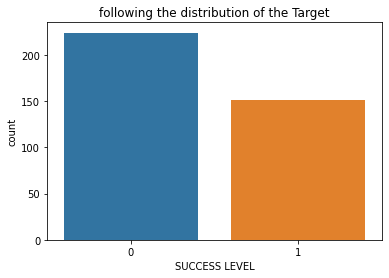

In [ ]:

num_pipeline = Pipeline(steps=[
    ('numerical_transformer',NumericalTransformer(cols=num_cols)),
    ('impute',SimpleImputer(strategy='mean')),
    ('standard_scalar',StandardScaler())
])


cat_pipeline = Pipeline([
    ('cat_transformer',CategoricalTransformer(cols=cat_cols)),
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder',OneHotEncoder(sparse=False, handle_unknown = 'ignore'))
])

full_pipeline = FeatureUnion([
    ('numerical_pipeline',num_pipeline),
    ('categorical_pipeline',cat_pipeline)
])

pipe = Pipeline([
    ('full_pipeline',full_pipeline)
])

traindf = pipe.fit_transform(X_train)

testdf = pipe.transform(X_test)

print(f'shape of Train data after transformation={traindf.shape}')
print(f'shape of Test data after transformation={testdf.shape}')
print(f'\nfollowing the distribution of the Target ')

x_axis, y_axis = np.unique(y, return_counts=True)
g = sns.countplot(y);
g.set(title='following the distribution of the Target');


In [ ]:
np.savetxt("./transformed_bestfeatures/xtrain.csv", traindf, delimiter=",")
np.savetxt("./transformed_bestfeatures/ytrain.csv", y_train, delimiter=",")

np.savetxt("./transformed_bestfeatures/xtest.csv", testdf, delimiter=",")
np.savetxt("./transformed_bestfeatures/ytest.csv", y_test, delimiter=",")

joblib.dump(pipe, './transformed_bestfeatures/obj_pipeline.pkl')   # include experiment # in the name

['./transformed_bestfeatures/obj_pipeline.pkl']

In [ ]:
!zip -r transformed_bestfeatures.zip transformed_bestfeatures

  adding: transformed_bestfeatures/ (stored 0%)
  adding: transformed_bestfeatures/xtrain.csv (deflated 98%)
  adding: transformed_bestfeatures/ytrain.csv (deflated 98%)
  adding: transformed_bestfeatures/ytest.csv (deflated 96%)
  adding: transformed_bestfeatures/obj_pipeline.pkl (deflated 67%)
  adding: transformed_bestfeatures/xtest.csv (deflated 98%)


In [ ]:
from google.colab import files
files.download("transformed_bestfeatures.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>